## PYPSA-USA Technical Appendix

PYPSA-USA Repository: https://github.com/PyPSA/pypsa-usa/tree/master


### PYPSA-USA Data Sources 

|Input Data | Description | Source |
| --- | --- | --- |
|BA_Shapes_new| Shape file used as inputs to produce geojson images. The shape file inputs return country and state boundary geojson .png files. | PYPSA-USA Repository/reo_data/BA_Shapes_new/Modified_BE_BA_Shapes.shp | 
| BOEM_CA_OSW_GIS| Shape file used as inputs to produce geojson images. The shape file inputs are specific to California and return onshore and offshore wind geojson .png files.| PYPSA-USA Repository/repo_data/BEOM_CA_OSW_GIS/CA_OSW_BOEM_CallAreas.Shp|
|NERC_Regions| Shape file used as input to produce geojson images for each NERC region and subregion.| PYPSA-USA Repository/repo_data/NERC_Regions/NERC_Regions_Subregions.shp|
|carbonconstraints | Data files that contain information on carbon capture rates for different types of coal and gas plants. Additionally, data is provided on carbon cap, carbon tax, methane leakage, and penalty rates.| PYPSA-USA Repository/ReEDS_Constraints|
|national_generation| General mandated technology list accompanied with a general mandated technology trajectory forecast up to 2040.|PYPSA-USA Repository/ReEDS_Constraints|
|reserves| Estimates on static and ramping levels at the balancing authority level (nercr) up to 2050.|PYPSA-USA Repository/ReEDS_Constraints|
|state_policies| Variety of state level data for energy mandates, offshore requirements and banned technologies.|PYPSA-USA Repository/ReEDS_Constraints|
|Transmissions| https://github.com/PyPSA/pypsa-usa/blob/master/workflow/repo_data/ReEDS_Constraints/transmission/README.md | TEPPC:  https://www.wecc.org/Administrative/TEPPC_TransCapCostCalculator_E3_2019_Update.xlsx, SCE: http://www.caiso.com/Documents/SCE2019DraftPerUnitCostGuide.xlsx|
|transmission_capacity_init_AC_NARIS2024.csv|  Initial AC transmission capacities between 134 US ReEDS zones. Calculated using the code available at https://github.nrel.gov/pbrown/TSC and nodal network data from NREL. The method is described by Brown, P.R. et al 2023, "A general method for estimating zonal transmission interface limits from nodal network data", in prep.| https://www.nrel.gov/docs/fy21osti/79224.pdf.|
|transmission_capacity_init_AC_REFS2009.csv| Initial AC transmission capacities between 134 US ReEDS zones. | https://www.nrel.gov/analysis/re-futures.html |
|membership| Data file containing NERC memberships at the transmission group level.| PYPSA-USA Repository/ReEDS_Constraints|
|Reeds_Shapes| Shape file used as an input to produce geojson images for Reeds regions.| PYPSA-USA Repository/repo_data/Reeds_Shapes|
|Locational_Mulipliers| Data files that contain project cost estimates for various energy requirements at Reeds regional multiplier locations.| PYPSA-USA Repository/repo_data_locational_multipliers|
|Plants| Data files for ADS plant locations, EIA 860 and ADS merged plants, other plants that have merged, fuels costs for 2022, and WECC fuel regions.| PYPSA-USA Repository/repo_data/plants|
|Anchor Data Set (ADS)| he Anchor Data Set (ADS) is intended to be a compilation of load, resource and transmission topology information used by the Regional Planning Groups (RPG) in the Western Interconnection as part of their regional transmission plans.| https://www.wecc.org/program-areas/reliability-planning-performance-analysis/reliability-modeling/anchor-data-set-ads| 
|Retrieve_casio_data| Historical daily natural gas fuel prices are retrieved from CAISO's Open Access Same-time Information System (OASIS). Data is collected on a daily basis for each Balancing Area and Fuel Region that had joined the Western Energy Imbalance Market (WEIM) during the time period designated in the configuration.| http://oasis.caiso.com/mrioasis/logon.do, |
|Retrieve_cost_data_eur| Pulls cost data from PYPSA-EU (Source is unclear at the moment)| Source Unknown|
|Retrieve_cost_data_usa| Retrieves cost data for USA. The script starts by pulling NREL ATB power generation data for a specified year (atb_year) then NREL ATB transportation data is collected. |https://oedi-datalake.s3.amazonaws.com/ATB/electricity/parquet/{atb_year}/ATBe.parquet, https://atb-archive.nrel.gov/transportation/2020/files/2020_ATB_Data_VehFuels_Download.xlsx|
|fuelCost22.csv| Values for fuel prices are pulled from the 2022 AEO for the 2021 year in $2021| https://www.eia.gov/outlooks/aeo/data/browser/#/?id=3-AEO2022&cases=ref2022&sourcekey=0|
|Retrieve_databundles| Pulls NREL EFS load profile zip files. The load profiles represent projected end-use electricity demand for various scenarios of electrification (Reference, Medium, High) and technology advancement (Slow, Moderate, Rapid), developed using the EnergyPATHWAYS (EP) model, as described in Mai et al. (2018). The EP load profiles were further calibrated for use in the ReEDS capacity expansion model (detailed in forthcoming EFS analyses), thus numerical values in this data set differ slightly from those reported in Mai et al. (2018). Load profiles are provided for a subset of years (2018, 2020, 2024, 2030, 2040, 2050) and are aggregated to the state, sector, and select subsector level.| https://data.nrel.gov/submissions/126|
|Retrieve_eulp| Module to download end use load profiles (eulp) for comstock and restock data. Data is downloaded at the state level, multisector 15 minute load profiles for a year which is fixed on 2018 Amy weather data.| https://data.openei.org/submissions/4520|
|Retrieve_forcast_data| Download forecast data from external sources (CEC, WECC). Files contain hourly forecast results developed as part of the California Energy Commission's 2022 Integrated Energy Policy Report Update.| https://efiling.energy.ca.gov/GetDocument.aspx?tn=248357, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248355, https://efiling.energy.ca.gov/GetDocument.aspx?tn=248353, https://www.wecc.org/Reliability/WECC%202030%20ADS%20PCM%202020-12-16%20(V1.5)%20Public%20Data.zip, https://www.wecc.org/Reliability/2032%20ADS%20PCM%20V2.3.2%20Public%20Data.zip|
|Retrieve_gridemissions_data| Historical electrical generation, demand, interchange, and emissions data are retrieved from the GridEmissions. Data is downloaded at hourly temporal resolution and at a spatial resolution of balancing authority region.|https://gridemissions.jdechalendar.su.domains/#/code.| 


In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pypsa
import gdown
import os
import sys
from datetime import datetime
from pathlib import Path
from typing import Dict
import netCDF4 as nc
import scipy
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import matplotlib.pyplot as plt
import atlite
import xarray as xr
import cartopy.crs as ccrs
from cartopy.crs import PlateCarree as plate
import cartopy.io.shapereader as shpreader

from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from matplotlib.lines import Line2D
from pypsa.statistics import StatisticsAccessor, get_bus_and_carrier
from _helpers import configure_logging
from add_electricity import add_nice_carrier_names, sanitize_carriers
from matplotlib.lines import Line2D
from summary import (
    get_capital_costs,
    get_demand_timeseries,
    get_energy_timeseries,
    get_fuel_costs,
    get_generator_marginal_costs,
    get_node_emissions_timeseries,
    get_tech_emissions_timeseries,
)

In [537]:
# Ensure that the pypsa-usa_technical_appendix.ipynb file is saved within the "workflow" folder of the PYPSA-USA repository.
current_dir = os.path.dirname(os.path.abspath('pypsa-usa_technical_appendix.ipynb'))

# Define path to scripts subfolder within the PYPSA-USA repository
subfolder_path = os.path.join(current_dir, 'scripts')
sys.path.append(subfolder_path)

In [539]:
# Import network
network = pypsa.Network()

# UPDATE to user specific file path for desried network
file_path = "C:/Users/alexa/Policy_Integrity/elec_s_145_ec_lv1.0_Ep_E_operations.nc"

# Import network from file
network.import_from_netcdf(path=file_path)

# Inital date of network. UPDATE ACCORDING TO YOUR NETWORK
inital_network_date = "2019-01-01"


INFO:pypsa.io:Imported network elec_s_145_ec_lv1.0_Ep_E_operations.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units


In [550]:
# Inital date of network. UPDATE ACCORDING TO YOUR NETWORK
initial_network_date = "2019-01-01"


In [541]:
# Define subcomponents of network
buses = network.buses
carriers = network.carriers
generators = network.generators
storage_units = network.storage_units
lines = network.lines
links = network.links

In [6]:
# Generate geopandas state boarders for capacity and demand maps.
STATES_TO_REMOVE = [
    "Hawaii",
    "Alaska",
    "Commonwealth of the Northern Mariana Islands",
    "United States Virgin Islands",
    "Guam",
    "Puerto Rico",
    "American Samoa",
]

shpfilename = shpreader.natural_earth(
    resolution="10m", category="cultural", name="admin_1_states_provinces"
)
reader = shpreader.Reader(shpfilename)
gdf_states = reader.records()
data = []
for r in gdf_states:
    attr = r.attributes
    if (attr["iso_a2"] in ["US"]) and (attr["name"] not in STATES_TO_REMOVE):
        data.append(
            [
                attr["name"],
                attr["iso_a2"],
                attr["latitude"],
                attr["longitude"],
                r.geometry,
            ]
        )
gdf_states = gpd.GeoDataFrame(
    data, columns=["name", "country", "x", "y", "geometry"]
).set_crs(4326)

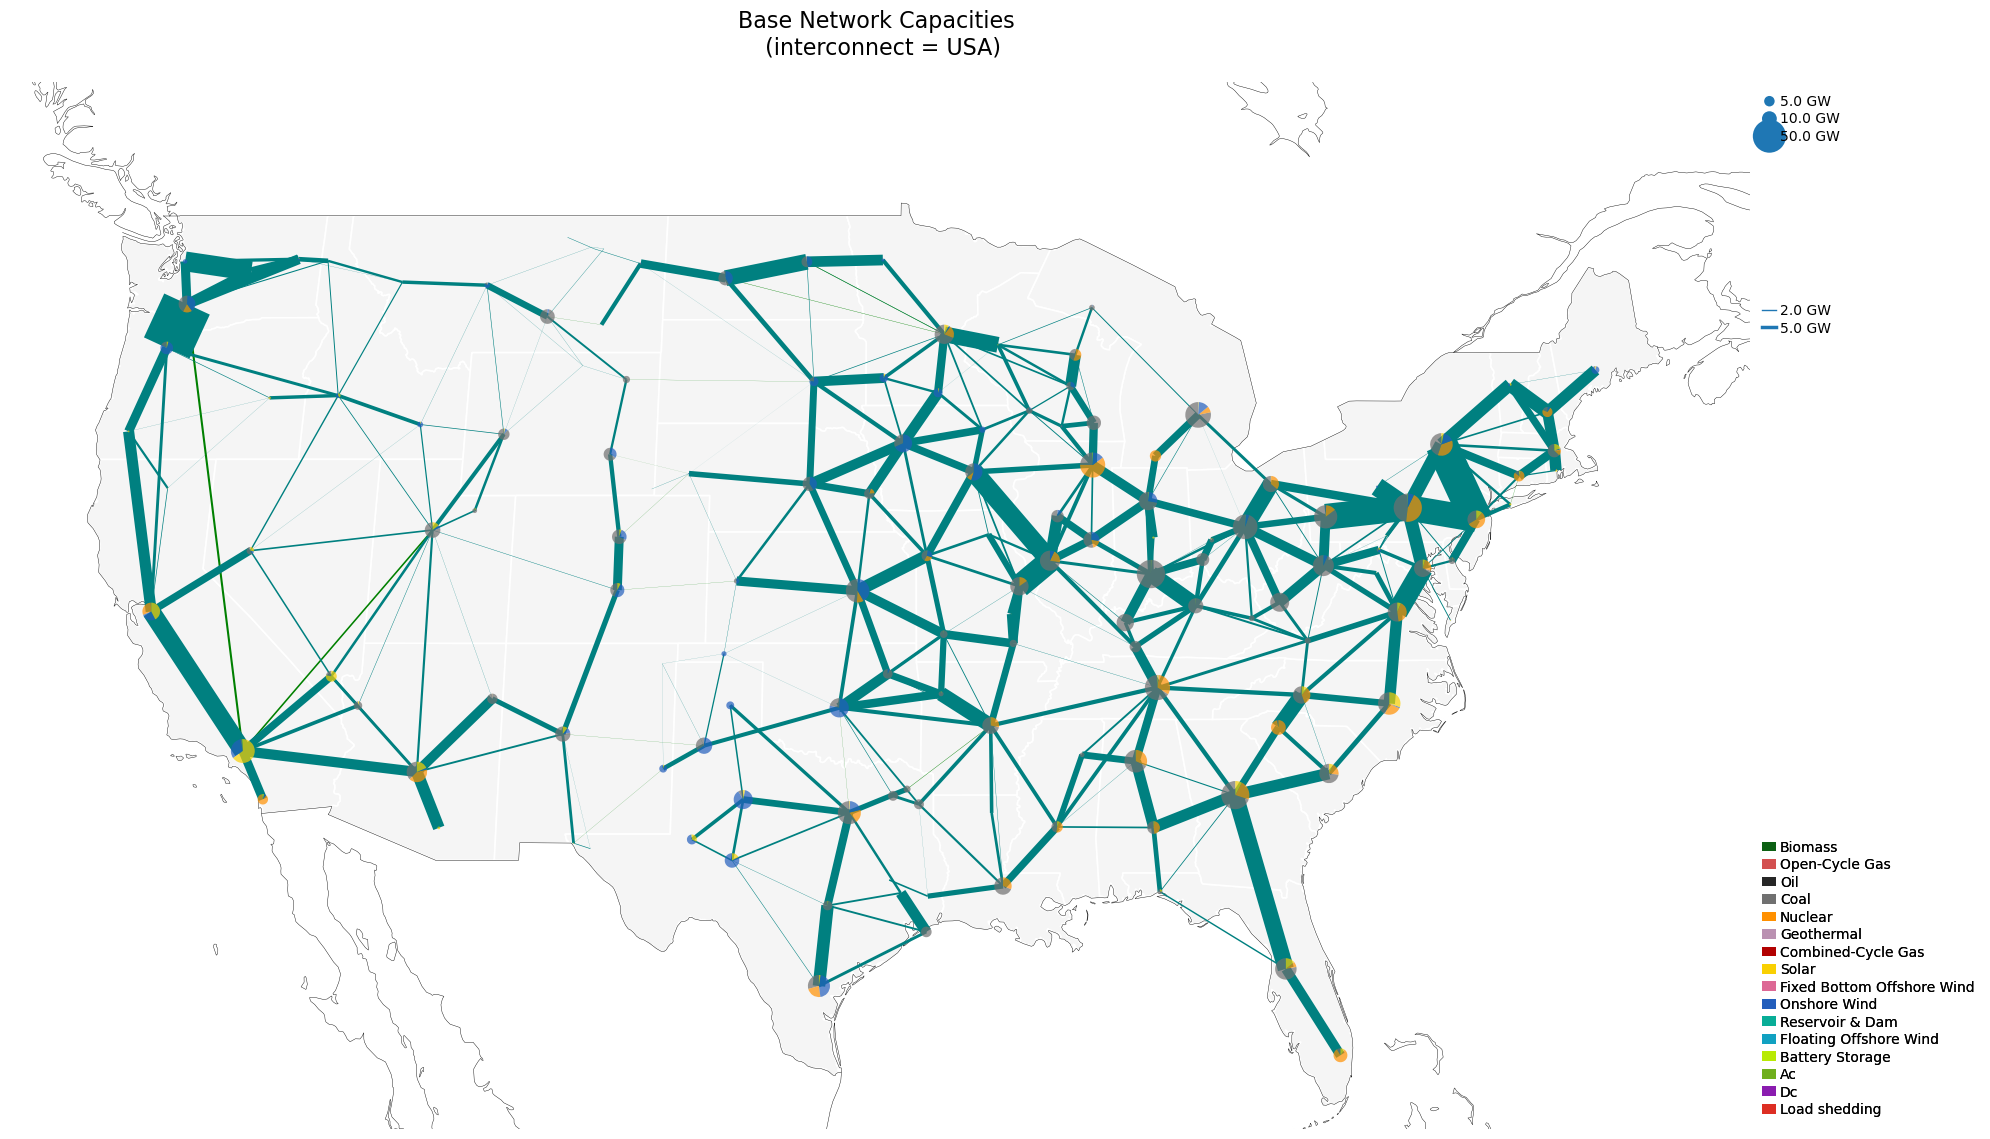

In [542]:
# Import capacity plot function from pypsa-usa scripts.
from plot_network_maps import plot_base_capacity_map, get_capacity_base

# Prevent legends from overlapping
plt.rcParams["legend.labelspacing"] = .25
plt.rcParams["legend.handlelength"] = 1
plt.rcParams["legend.handletextpad"] = .25

# Plot capacity map
plot_base_capacity_map(
    n=network,
    regions=gdf_states, 
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_capacity_map.png", # chan ge to users file path
    interconnect="USA",
)


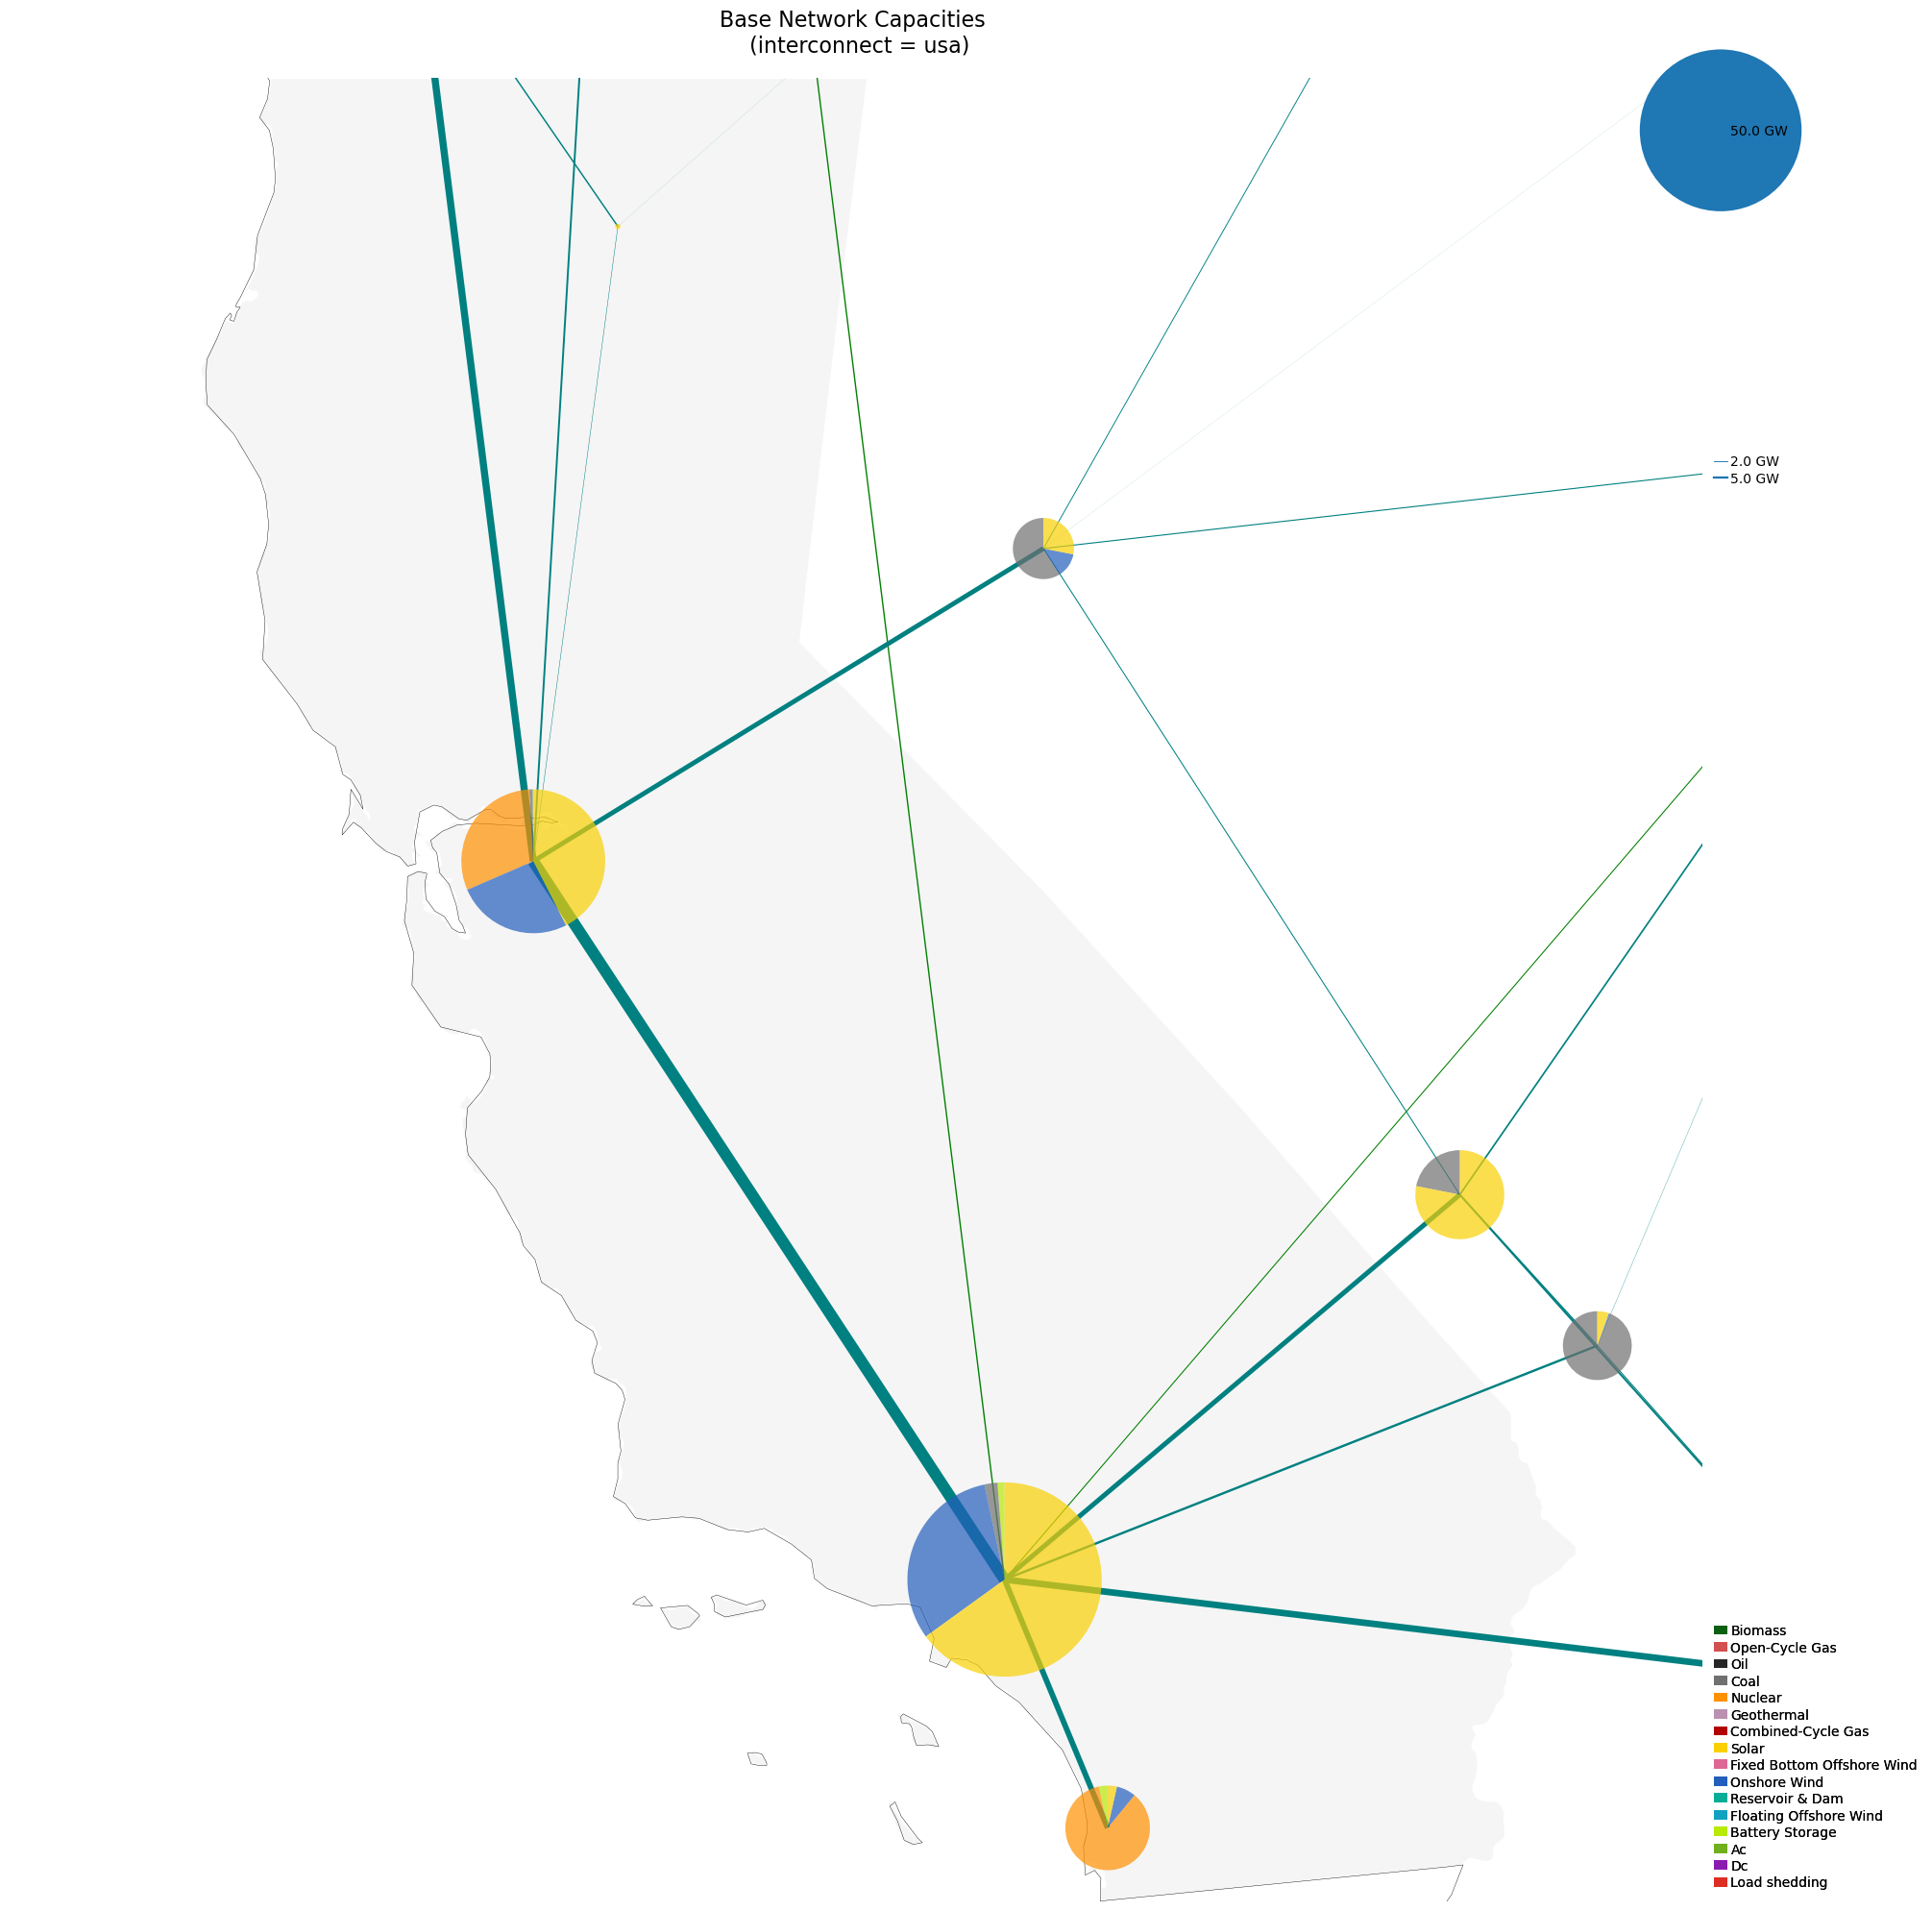

In [543]:
# Example of zooming in on particular state (California). To update, chanage "name == 'STATE'" to desired location. For state specific network, this map is not necessary.
plot_base_capacity_map(                                         
    n=network,
    regions=gdf_states.query("name == 'California'"), 
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_capacity_map.png",
    interconnect="usa",
)

## Summary of Input Data

### Energy Supply Statistics 

In [544]:
# primary energy (i.e. before conversion with losses by generators)
def get_primary_energy_use(n: pypsa.Network) -> pd.DataFrame:
    """
    Gets timeseries primary energy use by bus and carrier.
    """

    link_energy_use = (
        StatisticsAccessor(n)
        .withdrawal(
            comps=["Link", "Store", "StorageUnit"],
            aggregate_time=False,
            groupby=get_bus_and_carrier,
        )
        .droplevel("component")
    )

    gen_dispatch = (
        StatisticsAccessor(n)
        .supply(
            aggregate_time=False,
            comps=["Generator"],
            groupby=pypsa.statistics.get_name_bus_and_carrier,
        )
        .droplevel("component")
    )
    gen_eff = n.get_switchable_as_dense("Generator", "efficiency")

    gen_energy_use = gen_dispatch.T.mul(1 / gen_eff, axis=0, level="name").T.droplevel(
        "name",
    )

    return (
        pd.concat([gen_energy_use, link_energy_use])
        .groupby(["bus", "carrier"])
        .sum()
    )

energy_use = get_primary_energy_use(network)

# Add zonal features to energy use dataframe 
def add_zonal_features(energy_use: pd.DataFrame, buses: pd.DataFrame):
    """
    Returns energy_use dataframe with additional zonal features from buses dataframe.
    """
    buses_select = (buses[["reeds_zone", "reeds_ba", "interconnect", "reeds_state"]]
                    .reset_index()
                    .rename(columns={"Bus": "bus"}))

    energy_use_zonal = energy_use.reset_index()

    energy_use_zonal.columns = energy_use_zonal.columns.droplevel(1)

    energy_use_zonal = (energy_use_zonal.merge(buses_select, on="bus")
                                        .set_index(["bus", "carrier", "reeds_zone", 
                                        "reeds_ba", "interconnect", "reeds_state"]))

    energy_use.columns = [timestamp[1] for timestamp in energy_use.columns]
    energy_use.columns = pd.to_datetime(energy_use.columns)
    energy_use_zonal.columns = energy_use.columns

    return energy_use_zonal

energy_use_zonal = add_zonal_features(energy_use, buses)

# Average monthly energy_use_zonal
energy_use_zonal_monthly = energy_use_zonal.resample("M", axis=1).mean()

### Energy Demand Statistics

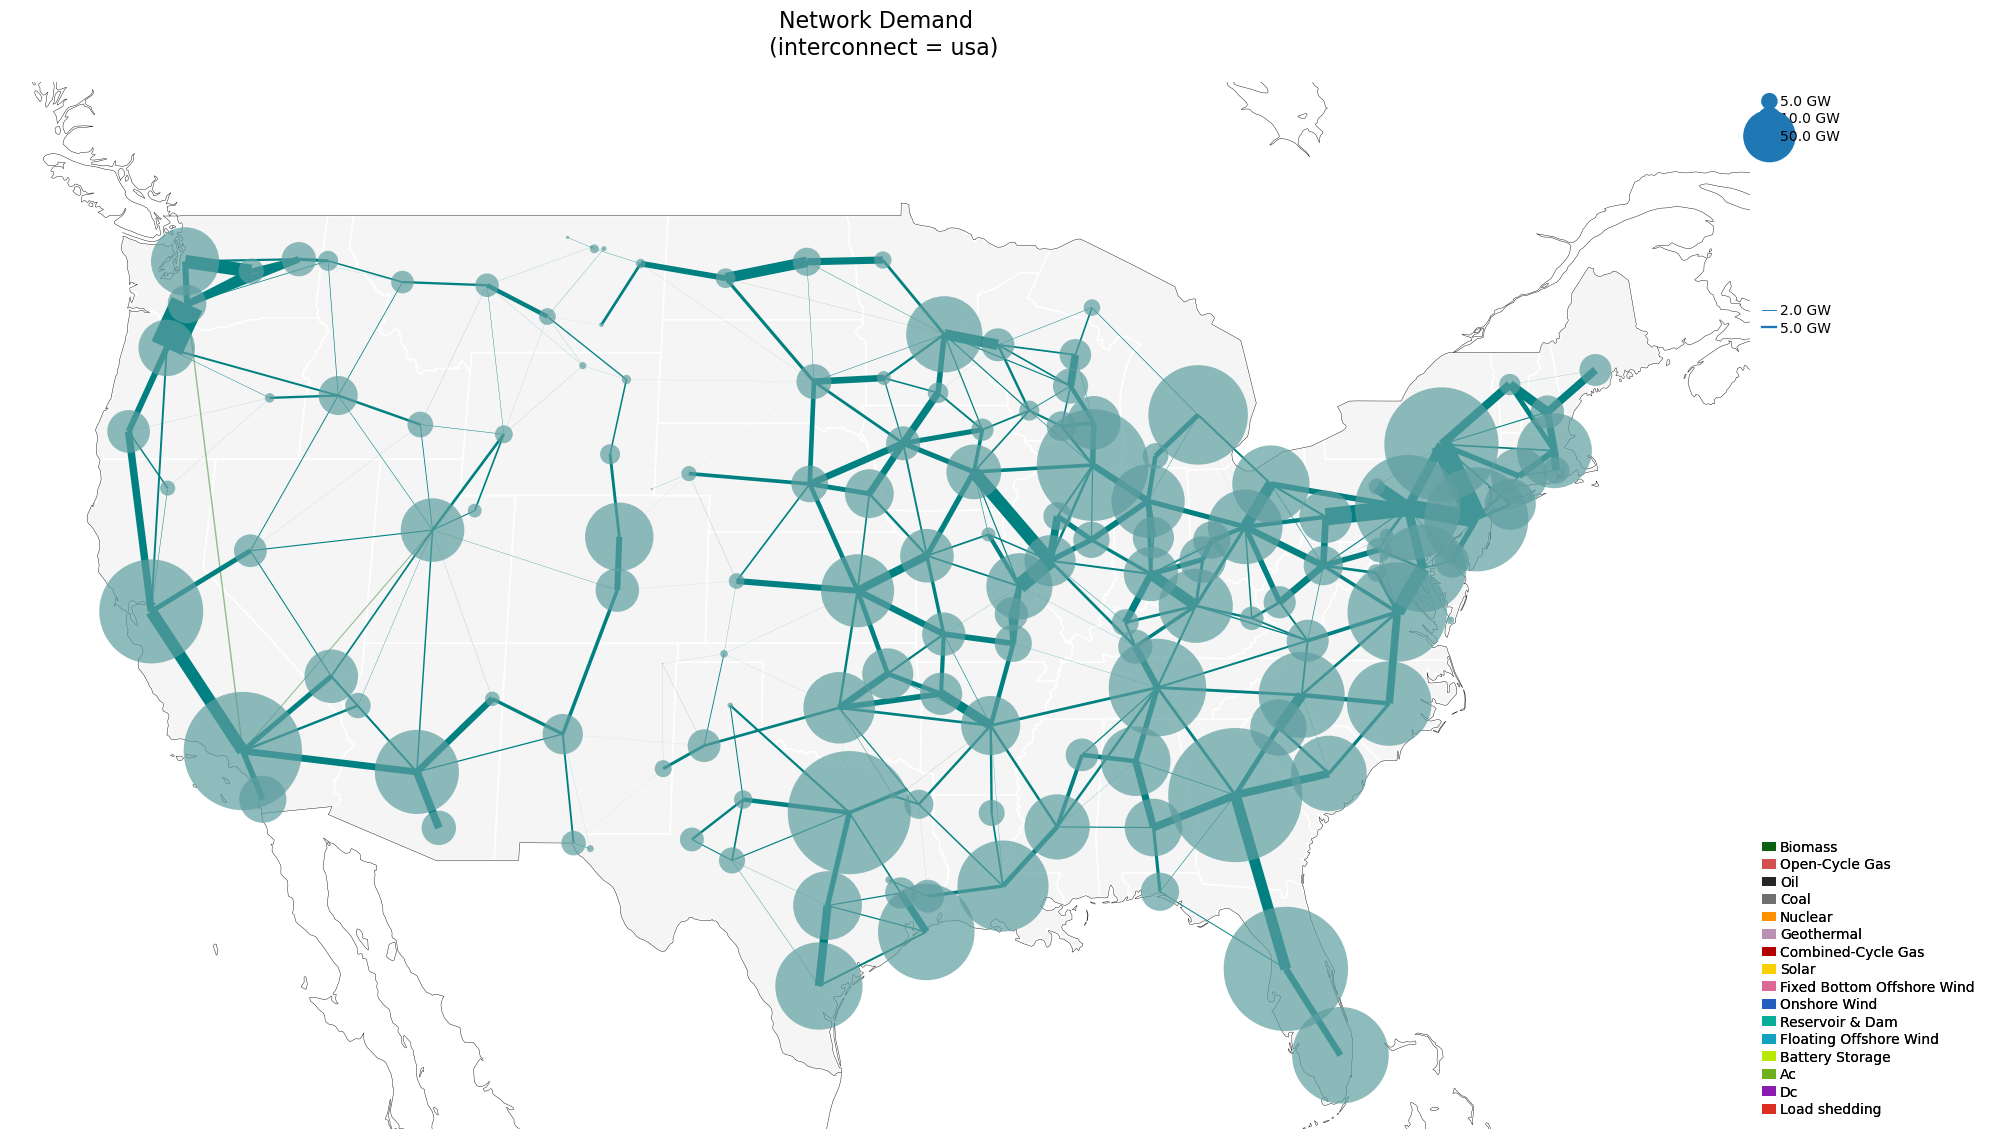

In [547]:
from plot_network_maps import plot_demand_map
import warnings
warnings.filterwarnings("ignore")

# Drop carrier type legend 


# plot demand map
plot_demand_map(
    n=network,
    regions=gdf_states,
    carriers=["solar", "wind", "onwind", "offwind", "ror", "nuclear", "gas", "coal", "battery"],
    save="C:/Users/alexa/Policy_Integrity/figures/USA_demand_map.png",
    interconnect="usa",
)

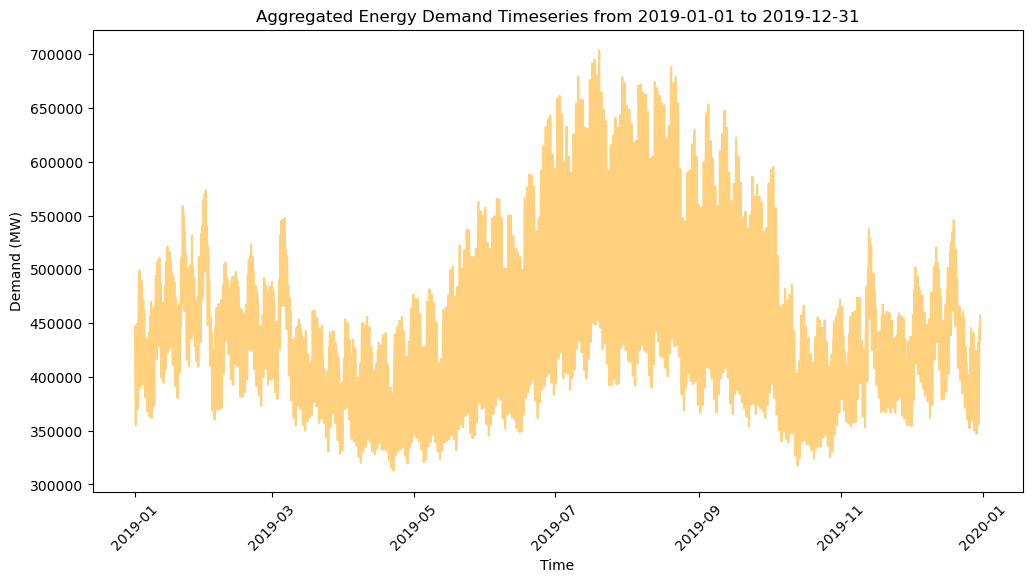

In [548]:
from summary import get_demand_timeseries, get_demand_base

# Get demand timeseries
demand_timeseries = get_demand_timeseries(network)

# Reset index then change timestep column to datetime object
demand_timeseries = demand_timeseries.reset_index()
demand_timeseries["timestep"] = pd.to_datetime(demand_timeseries["timestep"], format="%Y-%m-%d %H:%M:%S")

# Function to plot demand timeseries for a specified window of time. Dont include period in legend
def plot_demand_timeseries(demand_timeseries: pd.DataFrame, start_date: str, end_date: str):
    """
    Plots demand timeseries for a specified window of time.
    """
    # Select data for specified window of time
    data = demand_timeseries[(demand_timeseries["timestep"] >= start_date) & (demand_timeseries["timestep"] <= end_date)]

    # Plot demand
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(data["timestep"], 
    data["Demand"], 
    label="Demand (MWh)", 
    color="orange",
    alpha=0.5)
    ax.set_title(f"Aggregated Energy Demand Timeseries from {start_date} to {end_date}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Demand (MW)")
    plt.xticks(rotation=45)
    plt.show()


# Plot demand timeseries. Change start_date and end_date parameters to desired time period.
plot_demand_timeseries(demand_timeseries, "2019-01-01", "2019-12-31")

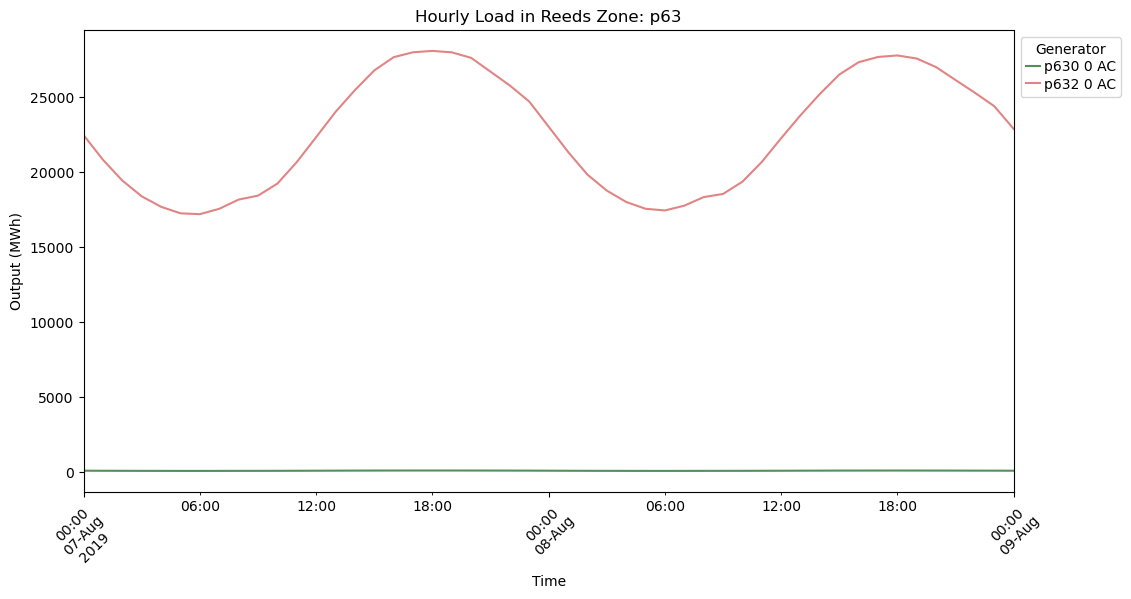

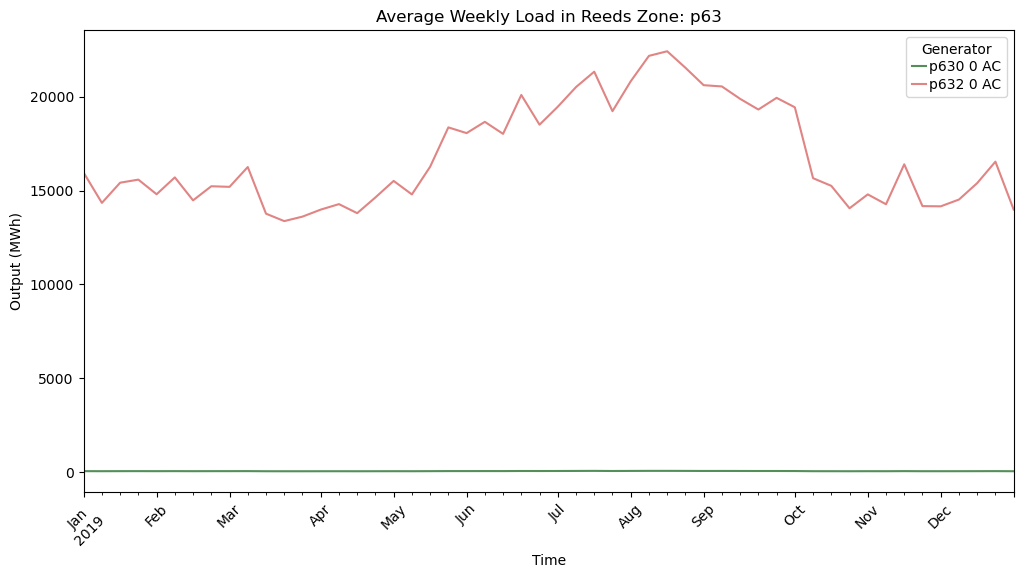

In [553]:
def loads_add_zonal(loads: pd.DataFrame, time_zone: str):
    """
    Network load data as an input and returns a dataframe with load data grouped by geographic features. Default time zone from PYPSA-USA
    is UTC. Convert to desried time zone in the format (US/Time Zone).
    """
    loads_zonal = loads.T

    # Make columns starting at 0 a timestep of data year (currently UTC). 
    loads_zonal.columns = pd.date_range(start=initial_network_date, 
    periods=len(loads_zonal.columns), 
    freq="H",
    tz="UTC")

    # Convert to desired time zone 
    est_time = loads_zonal.columns.tz_convert(time_zone)
    loads_zonal.columns = est_time.tz_localize(None)

    loads_zonal = loads_zonal.reset_index()
    loads_zonal["Bus"] = (loads_zonal["Load"]
    .str.replace('AC', '')
    .str.strip())

    buses_zonal = buses.reset_index()
    buses_zonal["Bus"] = (buses_zonal["Bus"]
    .str.replace('AC', '')
    .str.strip())

    # Set "Bus" as index for both DataFrames
    loads_zonal = loads_zonal.set_index("Bus")
    buses_zonal = buses_zonal.set_index("Bus")

    # Extract "reeds_zone" column from "buses" DataFrame
    reeds_zones = buses[["reeds_zone"]]

    # Join "reeds_zones" with "loads_zonal"
    loads_zonal = loads_zonal.join(reeds_zones, how="left").reset_index()

    loads_zonal["reeds_ba"] = loads_zonal["Bus"].map(buses.reeds_ba)
    loads_zonal["interconnect"] = loads_zonal["Bus"].map(buses.interconnect)
    loads_zonal["reeds_state"] = loads_zonal["Bus"].map(buses.reeds_state)


    loads_zonal = loads_zonal.set_index(["Bus", "reeds_zone", "reeds_ba", 
                                        "interconnect", "reeds_state", "Load"])

    return loads_zonal

#Load_t.p - active power at each bus (positive if neat load)
loads = (loads_add_zonal(network.loads_t.p, "US/Eastern")
        .groupby(["reeds_zone", "Load"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
        .mean()) 


def plot_data(generator:pd.DataFrame, reeds_zone: str, time_zone: str, start_date: str, end_date: str, title: str):
    """
    Plots desired load/generation data for a specified reeds zone, time zone and time period.
    """
    generator.columns = pd.date_range(start=initial_network_date, # update based on start date in data
    periods=len(generator.columns), 
    freq="H",
    tz = "UTC")

    # Convert to desired time zone 
    est_time = generator.columns.tz_convert(time_zone)
    generator.columns = est_time.tz_localize(None)

    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, color=carriers.color, alpha=0.7)
    ax.set_title(f"{title} in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

# Adjust start_date and end_date parameters as desired.
plot_data(loads, "p63", "US/Eastern", "2019-08-07", "2019-08-09", "Hourly Load")

# Generators_p weekly average 
loads_weekly = loads.resample("W", axis=1).mean()

def plot_data_weekly(generator:pd.DataFrame, reeds_zone: str, start_date: str, end_date: str, title: str):
    """
    Plots desried load/generation weekly average data for a specified reeds zone and time period.
    """
    # Select data for reeds zone
    data = generator.loc(axis=0)[reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, color=carriers.color, alpha=0.7)
    ax.set_title(f"{title} in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Generator", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()


# Adjust start_date and end_date parameters as desired.
plot_data_weekly(loads_weekly, "p63", "2019-01-01", "2019-12-30", "Average Weekly Load")

### Ouput (Dispatch Scenario)

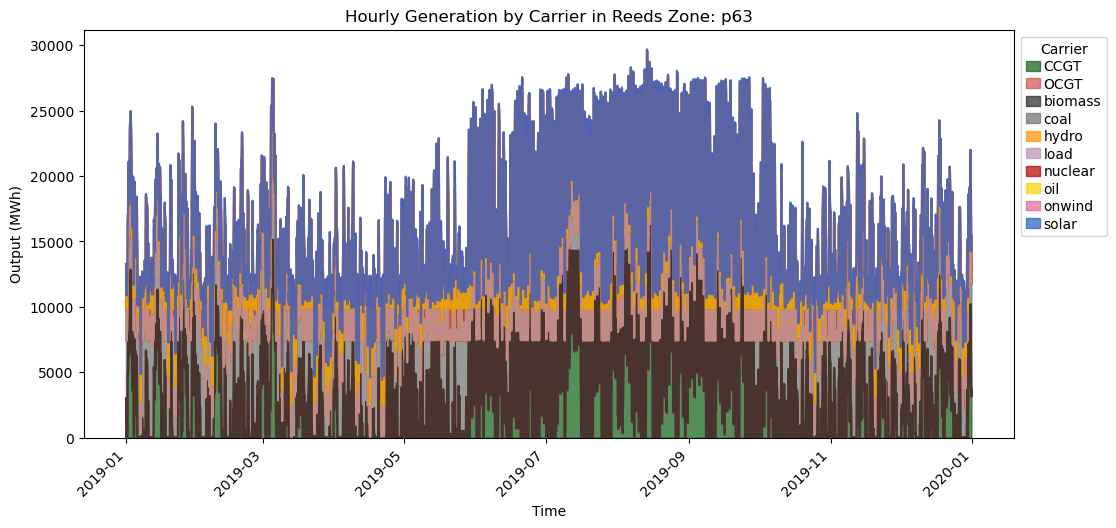

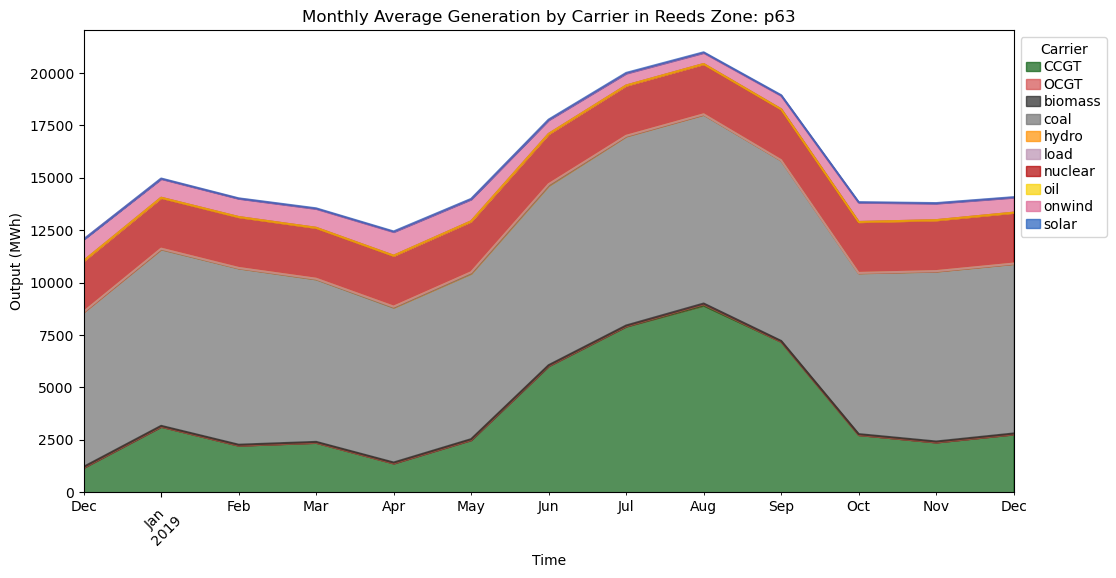

In [554]:
def generator_add_zonal(generator: pd.DataFrame, time_zone: str):
    """
    Takes specific generation data and returns a dataframe with geographic features.
    """
    generator_zonal = generator.T

    # Make columns starting at 0 a timestep of data year (currently UTC). 
    generator_zonal.columns = pd.date_range(start=initial_network_date, 
                                            periods=len(generator_zonal.columns), 
                                            freq="H",
                                            tz="UTC")

    # Convert to desired time zone 
    est_time = generator_zonal.columns.tz_convert(time_zone)
    generator_zonal.columns = est_time.tz_localize(None)

    generator_zonal.index.name = "generator"
    generator_zonal = generator_zonal.reset_index()
 
    generator_zonal["bus"] = generator_zonal["generator"].map(network.generators.bus)
    generator_zonal["reeds_zone"] = generator_zonal["bus"].map(buses.reeds_zone)
    generator_zonal["reeds_ba"] = generator_zonal["bus"].map(buses.reeds_ba)
    generator_zonal["interconnect"] = generator_zonal["bus"].map(buses.interconnect)
    generator_zonal["reeds_state"] = generator_zonal["bus"].map(buses.reeds_state)

    # create column that is generator type from generator 
    generator_zonal["generator_type"] = generator_zonal["generator"].map(network.generators.carrier)

    generator_zonal = generator_zonal.set_index(["bus", "reeds_zone", "reeds_ba", "reeds_state", 
                                    "interconnect", "generator", "generator_type"])

    return generator_zonal

generators_p = (generator_add_zonal(network.generators_t.p, "US/Eastern"))

def plot_generation_by_carrier(generators: pd.DataFrame, reeds_zone: str, title: str):
    """
    Plots area stacked chart of generation by carrier for a given reeds zone.
    """
    # Select data for reeds zone. If intereted in alternate  geographic feature (i.e interconnection), update here by changing selected index.
    data = generators.loc(axis=0)[:, reeds_zone, :, :, :].groupby(["generator_type"]).sum().T

    # Plot data. Use get_color_palette() to get a list of colors for the plot.
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot.area(ax=ax, color = carriers.color, alpha=0.7) # fix color to use carrier.color
    ax.set_title(f"{title} Generation by Carrier in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Carrier", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)

    plt.show()

# Plot generation by carrier for the specified interconnection
plot_generation_by_carrier(generators_p, "p63", "Hourly")


# Make columns datetime objects and get monthly means
generators_p.columns = pd.to_datetime(generators_p.columns)
generators_p_weekly = generators_p.resample("W", axis=1).mean()
generators_p_monthly = generators_p.resample("M", axis=1).mean()

plot_generation_by_carrier(generators_p_monthly, "p63", "Monthly Average")

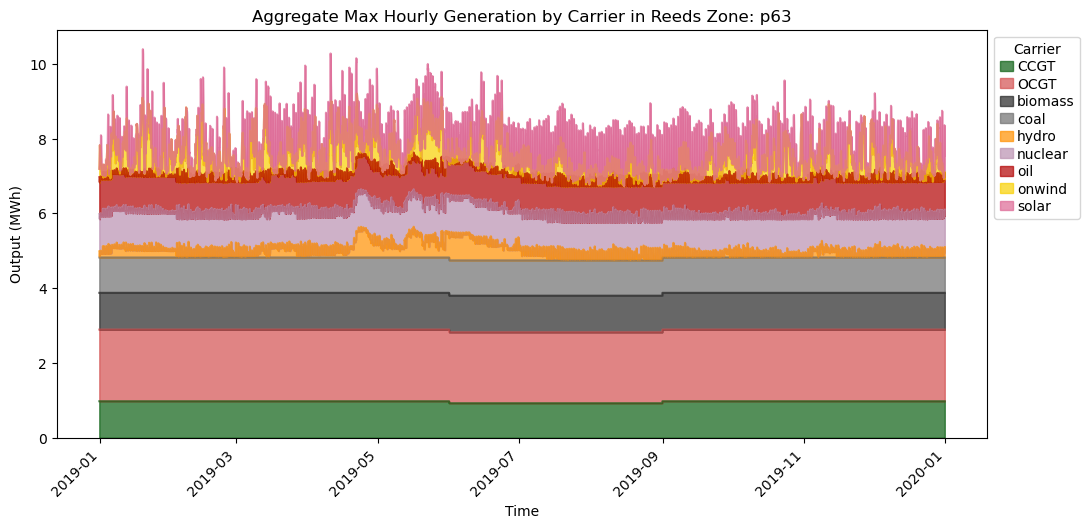

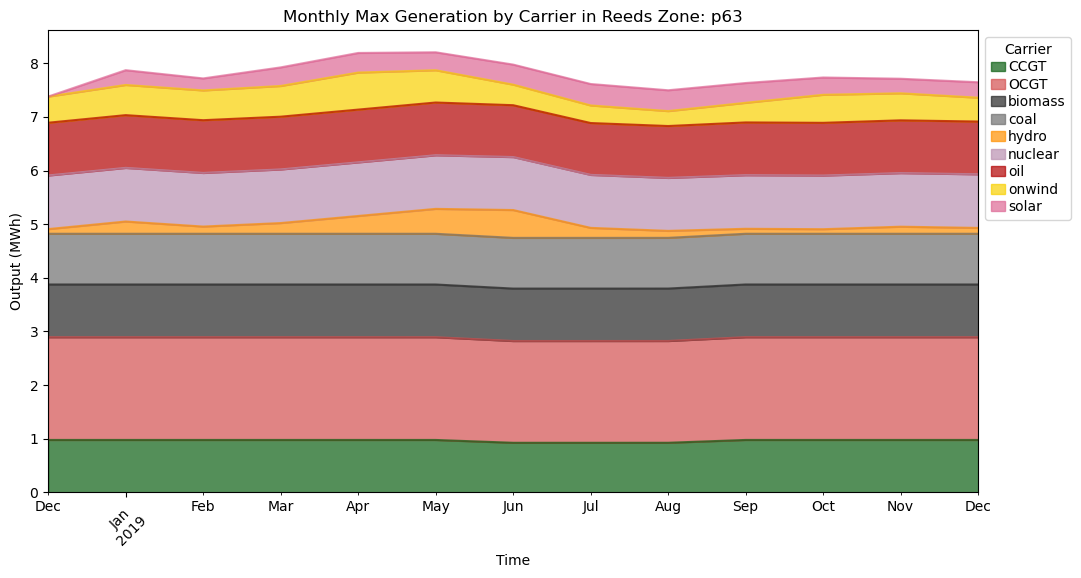

In [555]:
# Import generators-p_max_pu data: The maximum output for each snapshot per unit of p_nom for the optimization 
# (e.g. for variable renewable generators this can change due to weather conditions; for conventional generators it represents a maximum dispatch).
generators_p_max = (generator_add_zonal(network.generators_t.p_max_pu, "US/Eastern")).reset_index()

# Create column that is generator type from generator 
generators_p_max["generator_type"] = generators_p_max["generator"].map(network.generators.carrier)
generators_p_max = generators_p_max.set_index(["bus", "reeds_zone", "reeds_ba", "reeds_state", 
                                    "interconnect", "generator", "generator_type"])

# Plot generation by carrier for the specified interconnection
plot_generation_by_carrier(generators_p_max, "p63", "Aggregate Max Hourly")


# Make columns datetime objects and get monthly means
generators_p_max.columns = pd.to_datetime(generators_p_max.columns)
generators_p_max_monthly = generators_p_max.resample("M", axis=1).mean()

plot_generation_by_carrier(generators_p_max_monthly, "p63", "Monthly Max")


### Costs


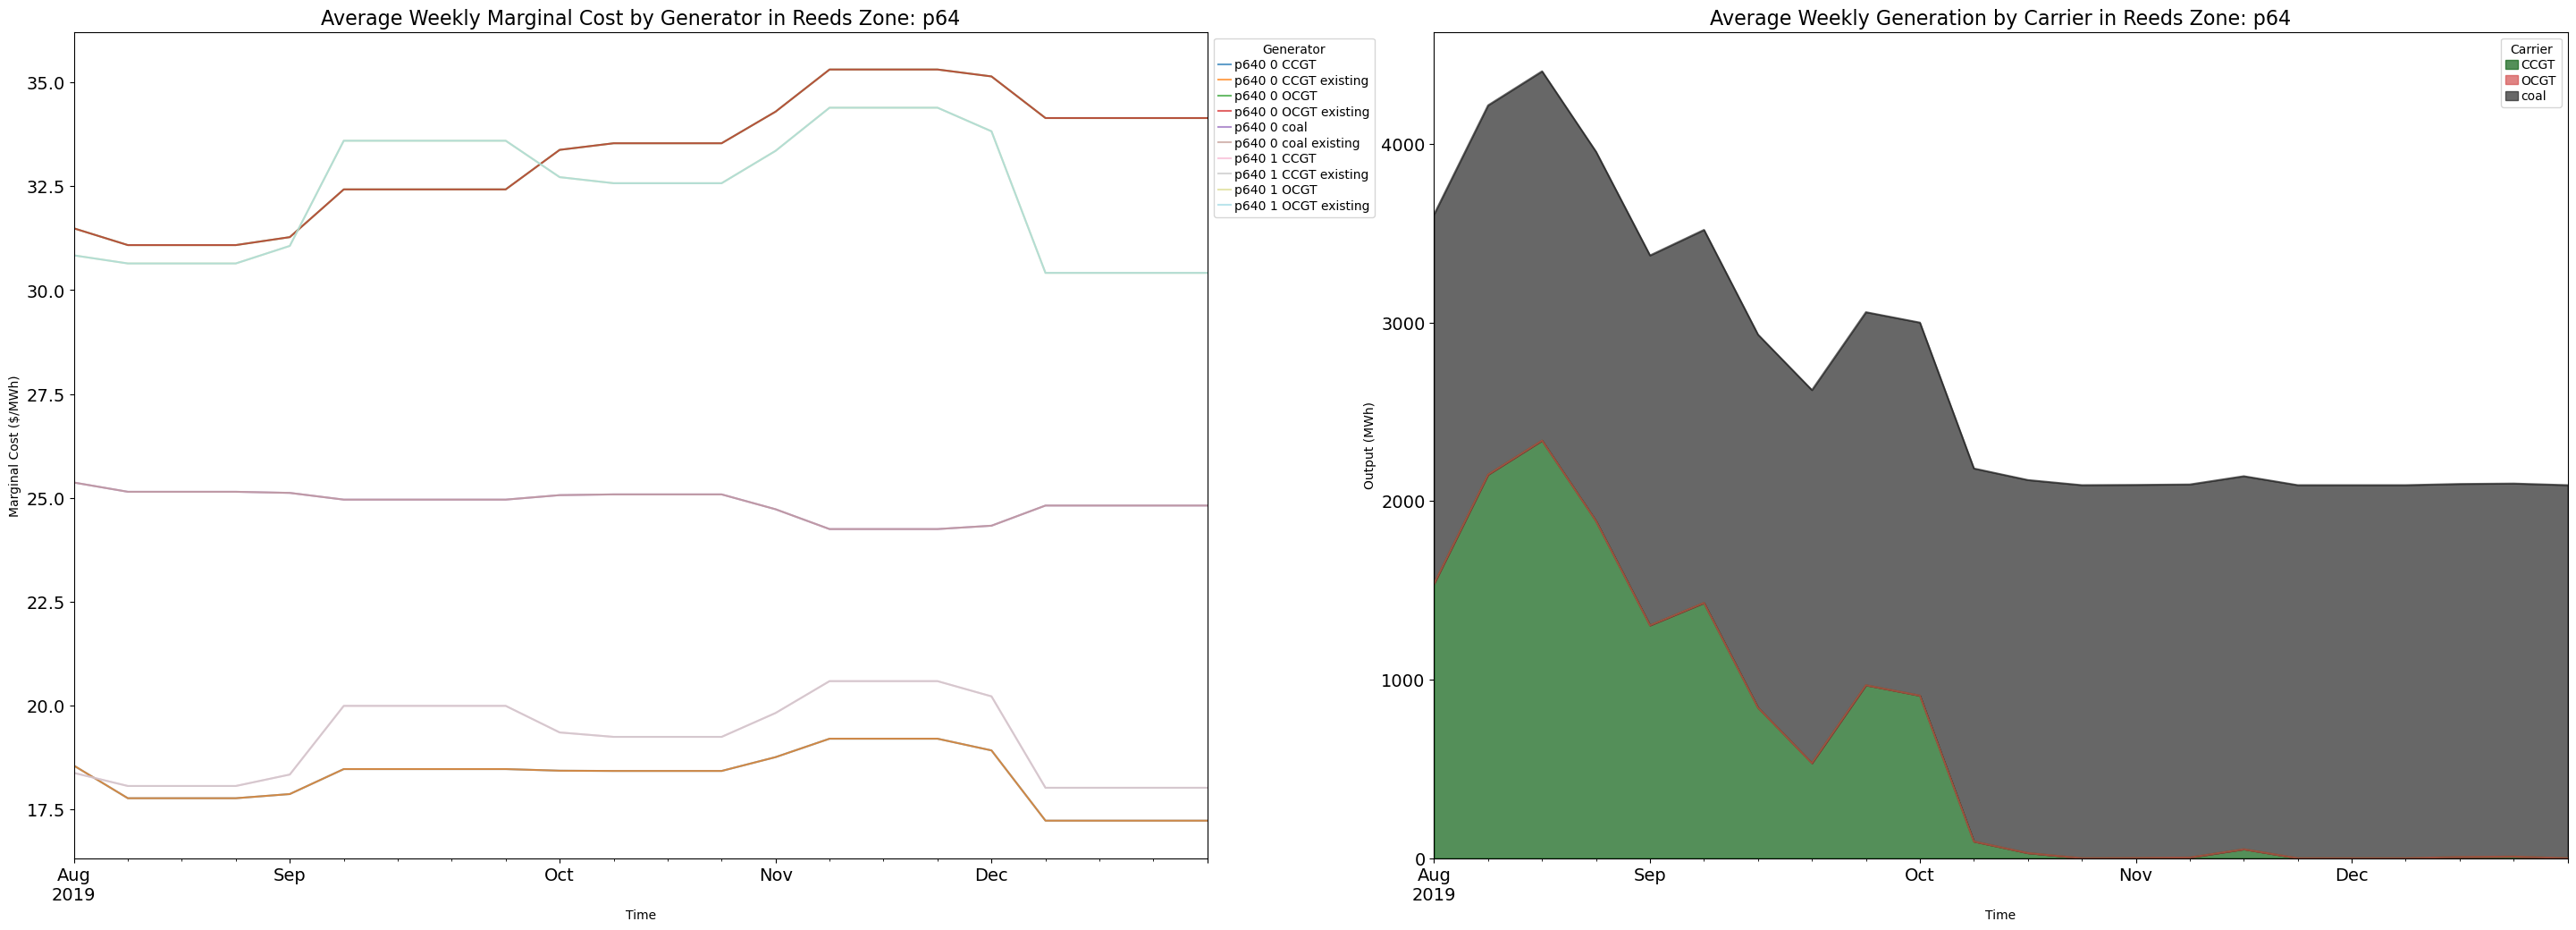

In [556]:
def plot_generators_mc_weekly(generator_mc: pd.DataFrame, generators_p: pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots average weekly marginal cost by generator for a specified reeds zone and time period.
    """
    generator_mc.columns = pd.date_range(start=initial_network_date, 
    periods=len(generator_mc.columns), 
    freq="H")

    generators_mc_weekly = (generator_mc
                        .resample("W", axis=1)
                        .mean())

    # Select data for reeds zone. If interested in alternate geographic feature (i.e interconnection), update here by changing selected index.
    data_mc = generators_mc_weekly.loc(axis=0)[reeds_zone].T
    data_mc = data_mc[(data_mc.index >= start_date) & (data_mc.index <= end_date)]

    # Select data for reeds zone
    data_p = generators_p.loc(axis=0)[:, reeds_zone, :, :, :].groupby(["generator_type"]).sum().T  

    # limit data_p to only generators of type CCGT, OCGT, and coal
    data_p = data_p.loc[:, data_p.columns.isin(["CCGT", "OCGT", "coal"])]
    data_p = data_p[(data_p.index >= start_date) & (data_p.index <= end_date)]

    # Plot marginal cost and generators_p next to each other
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(36, 12))
    data_mc.plot(ax=ax1, cmap="tab20", alpha=0.7)
    data_p.plot.area(ax=ax2, color = carriers.color, alpha=0.7) # fix color to use carrier.color

    ax1.set_title(f"Average Weekly Marginal Cost by Generator in Reeds Zone: {reeds_zone}", size=16)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Marginal Cost ($/MWh)")
    ax1.legend(title="Generator", bbox_to_anchor=(1, 1))
    ax1.tick_params(axis='both', which='major', labelsize=14)

    ax2.set_title(f"Average Weekly Generation by Carrier in Reeds Zone: {reeds_zone}", size=16)
    
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Output (MWh)")
    ax2.legend(title="Carrier", bbox_to_anchor=(1, 1))
    ax2.tick_params(axis='both', which='major', labelsize=14)


# Adjust start_date and end_date parameters to desired window.
plot_generators_mc_weekly(generators_mc, generators_p_weekly, 'p64', "2019-08-01", "2019-12-30")

### Storage 

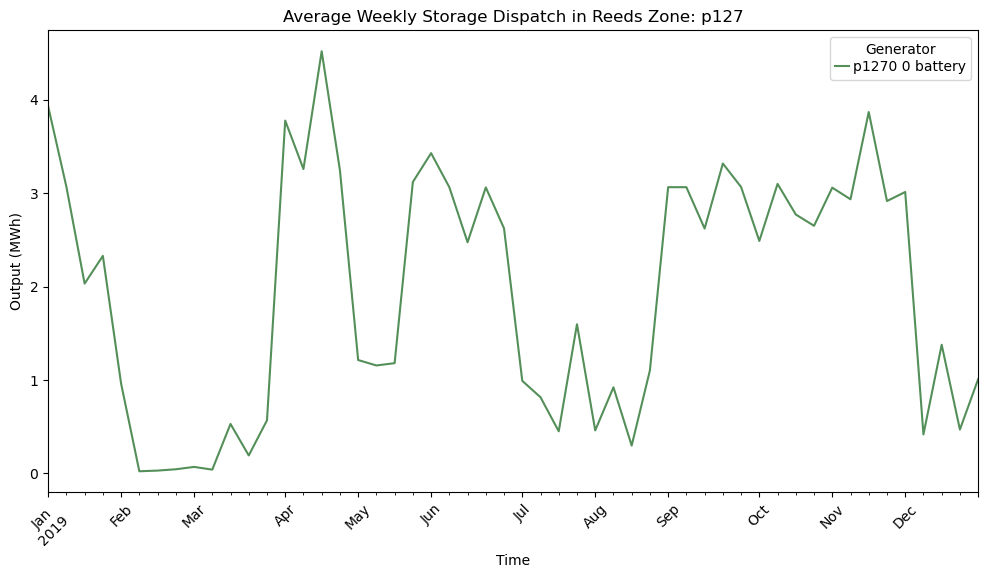

In [560]:
def storage_add_zonal(storage: pd.DataFrame, time_zone: str):
    """
    Network storage data as an input and returns a dataframe with storage data grouped by geographic features. Default time zone from PYPSA-USA
    is UTC. Convert to desried time zone in the format (US/Time Zone).
    """
    storage_zonal = storage.T

    # Make columns starting at 0 a timestep of data (currently UTC)
    storage_zonal.columns = pd.date_range(start=initial_network_date, 
    periods=len(storage_zonal.columns), 
    freq="H",
    tz="UTC")

    # Convert to desired time zone 
    est_time = storage_zonal.columns.tz_convert(time_zone)
    storage_zonal.columns = est_time.tz_localize(None)

    storage_zonal = storage_zonal.reset_index()
    storage_zonal["Bus"] = (storage_zonal["StorageUnit"]
    .str.replace('battery', '')
    .str.strip())

    buses_zonal = buses.reset_index()
    buses_zonal["Bus"] = (buses_zonal["Bus"]
    .str.replace('battery', '')
    .str.strip())

    # Set "Bus" as index for both DataFrames
    storage_zonal = storage_zonal.set_index("Bus")
    buses_zonal = buses_zonal.set_index("Bus")

    # Extract "reeds_zone" column from "buses" DataFrame
    reeds_zones = buses[["reeds_zone"]]

    # Join "reeds_zones" with "loads_zonal"
    storage_zonal = storage_zonal.join(reeds_zones, how="left").reset_index()

    storage_zonal["reeds_ba"] = storage_zonal["Bus"].map(buses.reeds_ba)
    storage_zonal["interconnect"] = storage_zonal["Bus"].map(buses.interconnect)
    storage_zonal["reeds_state"] = storage_zonal["Bus"].map(buses.reeds_state)

    storage_zonal = storage_zonal.set_index(["Bus", "reeds_zone", "reeds_ba", 
                                        "interconnect", "reeds_state", "StorageUnit"])

    return storage_zonal


#storage_units_t.p_dispatch - active power dispatch at bus
storage_dispatch = (storage_add_zonal(network.storage_units_t.p_dispatch, "US/Eastern")
                    .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
                    .mean()) 

storage_dispatch.columns = pd.to_datetime(storage_dispatch.columns)
storage_dispatch_weekly = storage_dispatch.resample("W", axis=1).mean()

# Adjust start_date and end_date parameters to desired window.
plot_data_weekly(storage_dispatch_weekly, "p127", "2019-01-01", "2019-12-30", "Average Weekly Storage Dispatch")

In [569]:
# Import storage_units_p_store - active power charging at bus 
storage_store = (storage_add_zonal(network.storage_units_t.p_store, "US/Eastern")
                .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
                .mean()) 

storage_store.columns = pd.to_datetime(storage_store.columns)
storage_store_weekly = storage_store.resample("W", axis=1).mean()

# Very similar plot to the one above. Not generating much additional information.
#plot_data_weekly(storage_store_weekly, "p127", "2019-01-01", "2019-12-31", "Average Weekly Active Power Storage")

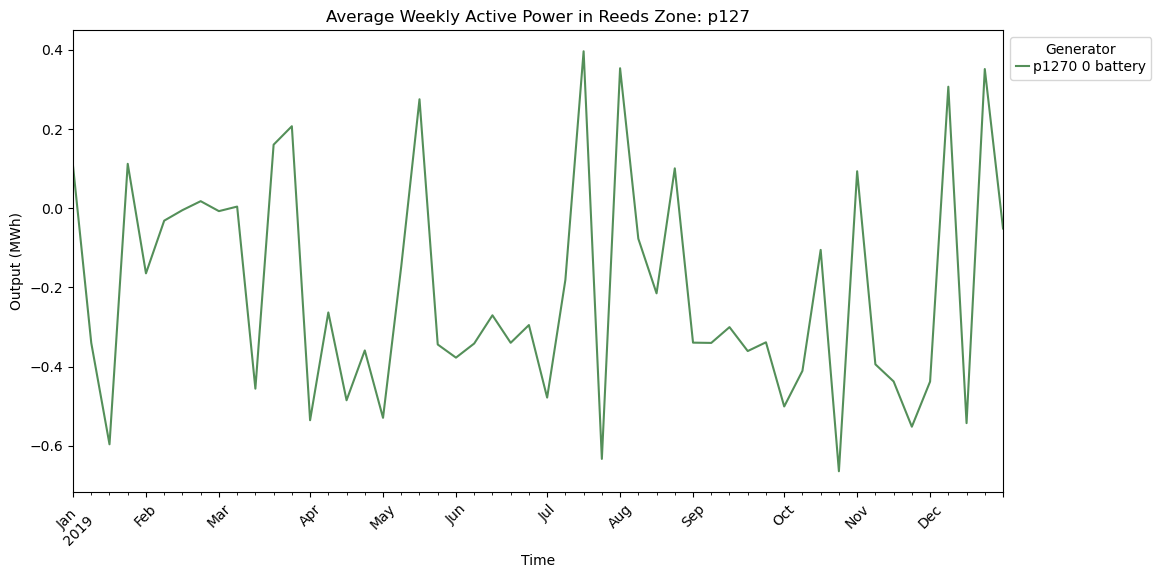

In [564]:
# Import storage_units_t - active power at bus (positive if net generation)
storage_p = (storage_add_zonal(network.storage_units_t.p, "US/Eastern")
            .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
            .mean()) 

storage_p.columns = pd.to_datetime(storage_p.columns)
storage_p_weekly = storage_p.resample("W", axis=1).mean()

plot_data_weekly(storage_p_weekly, "p127","2019-01-01", "2019-12-31", "Average Weekly Active Power")

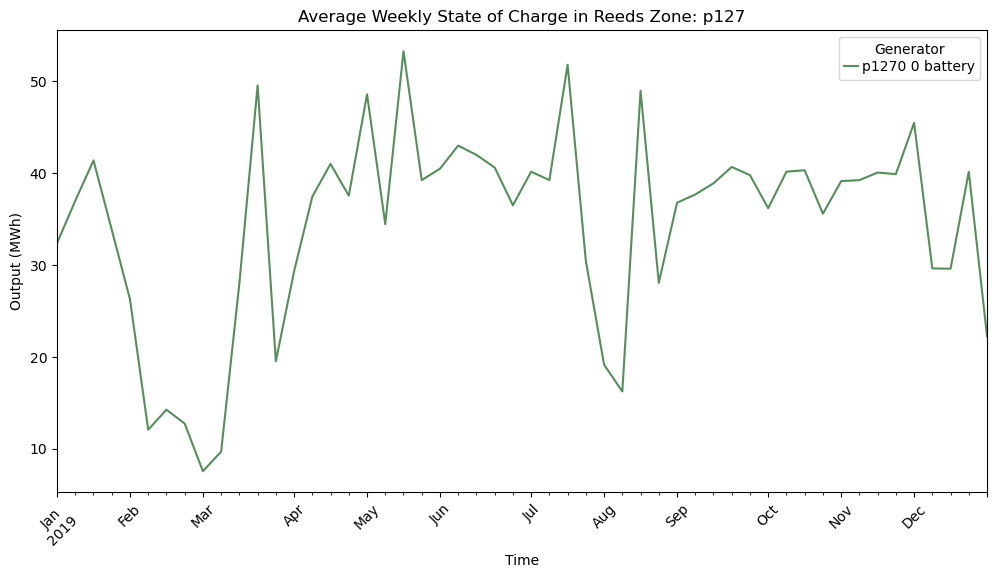

In [565]:
# Import storage_units_t_state_of_charge - state of charge as calculated by the OPF.
storage_state_charge = (storage_add_zonal(network.storage_units_t.state_of_charge, "US/Eastern")
                        .groupby(["reeds_zone", "StorageUnit"]) # Change groupby to desired setting (i.e reeds_state). Update plotting function accordingly.
                        .mean()) 


storage_state_charge.columns = pd.to_datetime(storage_state_charge.columns)
storage_state_weekly = storage_state_charge.resample("W", axis=1).mean()

plot_data_weekly(storage_state_weekly, "p127", "2019-01-01", "2019-12-30", "Average Weekly State of Charge")


### Lines Transmission

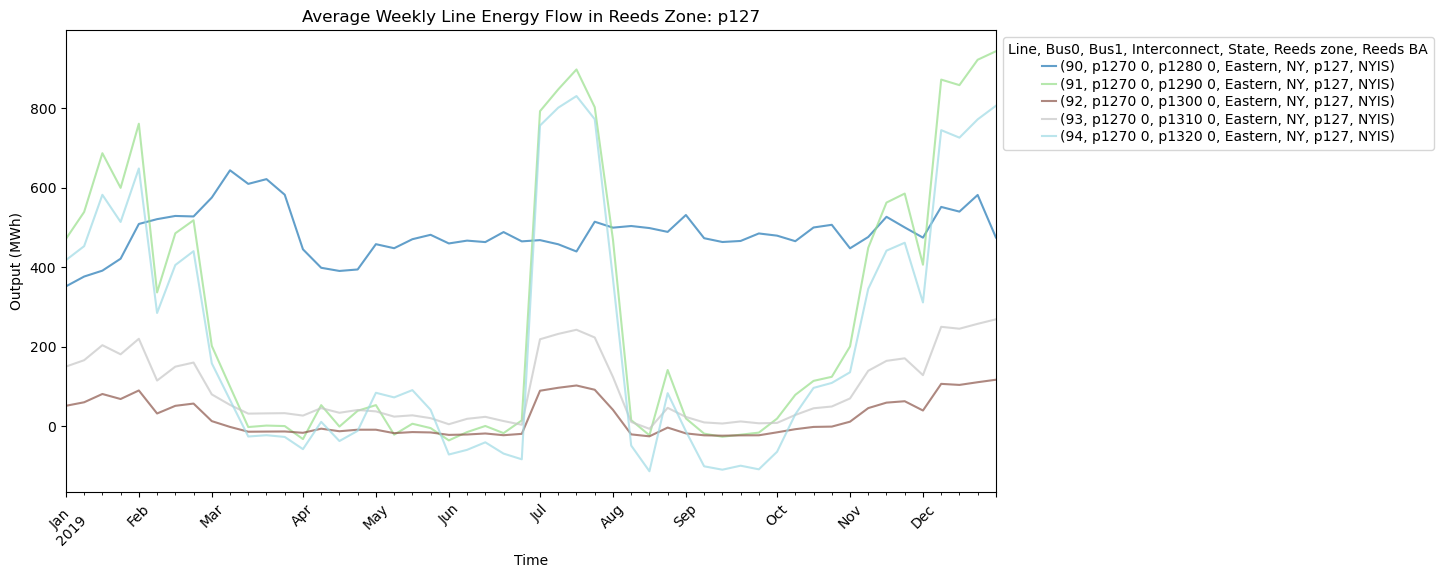

In [573]:
def lines_add_zonal(line: pd.DataFrame, time_zone: str):
    """
    Line_p0 or line_p1 pandas dataframe as an input and returns a dataframe with line active power flow with geographic features. Default time zone from PYPSA-USA
    is UTC. Convert to desried time zone in the format (US/Time Zone).

    Line_p0 - Active power at bus0

    line_p1 - Active power at bus1
    """                                                                                                                                                                                                           
    line_zonal = line.T.reset_index()

    line_zonal.columns = line_zonal.columns.droplevel(1)

    lines_select = (network.lines[["bus0", "bus1", "interconnect"]]
                    .reset_index())

    line_zonal = (line_zonal.merge(lines_select, on="Line")
                            .set_index(["Line", "bus0", "bus1", "interconnect"]))
              
    # Make columns starting at 0 a timestep of first day of data year (currently UTC).
    line_zonal.columns = pd.date_range(start=initial_network_date, 
    periods=len(line_zonal.columns), 
    freq="H",
    tz="UTC")

    # Convert to desired time zone 
    est_time = line_zonal.columns.tz_convert(time_zone)
    line_zonal.columns = est_time.tz_localize(None)


    # Extract "reeds_zone" column from "buses" DataFrame
    reeds_zones = (buses[["reeds_zone"]].reset_index()
                    .rename(columns={"Bus": "bus0"})) # change rename based on input data (i.e using lines_p0 use bus0)

    # Map reeds zone
    line_zonal = line_zonal.reset_index()
    line_zonal = line_zonal.merge(reeds_zones, on="bus0")


    line_zonal["reeds_ba"] = line_zonal["bus0"].map(buses.reeds_ba)
    line_zonal["reeds_state"] = line_zonal["bus0"].map(buses.reeds_state)

    line_zonal = line_zonal.set_index(["Line", "bus0", "bus1", 
                                        "interconnect", "reeds_state", "reeds_zone", "reeds_ba"])

    return line_zonal

lines0_zonal = lines_add_zonal(network.lines_t.p0, "US/Eastern")

# Weekly mean of line energy flow 
lines0_zonal.columns = pd.to_datetime(lines0_zonal.columns)
lines0_weekly = lines0_zonal.resample("W", axis=1).mean()

# function to plot lines0_weekly for specified reeds_zone. Plots all the lines in the zone. 
def plot_lines_weekly(lines: pd.DataFrame, reeds_zone: str, start_date: str, end_date: str):
    """
    Plots average weekly line energy flow for a specified reeds zone and time period.
    """
    # Select data for reeds zone
    data = lines.loc(axis=0)[:, :, :, :, :, reeds_zone].T
    data = data[(data.index >= start_date) & (data.index <= end_date)]

    # Plot data
    fig, ax = plt.subplots(figsize=(12, 6))
    data.plot(ax=ax, cmap="tab20", alpha=0.7)
    ax.set_title(f"Average Weekly Line Energy Flow in Reeds Zone: {reeds_zone}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Output (MWh)")
    ax.legend(title="Line, Bus0, Bus1, Interconnect, State, Reeds zone, Reeds BA", bbox_to_anchor=(1, 1))
    plt.xticks(rotation=45)
    plt.show()

plot_lines_weekly(lines0_weekly, "p127", "2019-01-01", "2019-12-31")

In [612]:
lines0_weekly.head()

,,,,,,,2019-01-06,2019-01-13,2019-01-20,2019-01-27,2019-02-03,2019-02-10,2019-02-17,2019-02-24,2019-03-03,2019-03-10,...,2019-11-03,2019-11-10,2019-11-17,2019-11-24,2019-12-01,2019-12-08,2019-12-15,2019-12-22,2019-12-29,2020-01-05
Line,bus0,bus1,interconnect,reeds_state,reeds_zone,reeds_ba,,,,,,,,,,,,,,,,,,,,,
0,p1000 0,p1160 0,Eastern,VA,p100,PJM,-449.175187,-414.712531,-399.089279,-355.052088,-320.845268,-443.455486,-432.226614,-443.887922,-435.634179,-391.361375,...,-476.106183,-476.767096,-423.452070,-460.025942,-488.996245,-438.708791,-437.229216,-391.655928,-496.913669,-522.172832
1,p1000 0,p990 0,Eastern,VA,p100,PJM,142.804265,72.216202,45.206646,-19.012501,-76.397499,106.243794,80.240544,95.356869,82.938233,20.245266,...,182.381914,164.168733,81.795599,136.697196,182.430390,97.606377,92.685125,24.267643,191.968490,226.589770
10,p1030 0,p1040 0,Eastern,MI,p103,MISO,1395.015166,1191.150153,926.107968,619.346279,558.105070,1045.515326,1268.015522,1077.810342,906.841513,686.287814,...,1236.819329,1389.909851,843.844966,1197.063345,1245.816049,1134.528249,1079.093552,553.642814,1561.471153,786.843952
100,p1300 0,p1340 0,Eastern,NH,p130,ISNE,331.875807,290.858529,471.010546,337.647841,488.759967,180.729789,351.328547,380.864930,180.581658,311.321231,...,363.008047,426.461114,484.077680,485.844505,134.977791,391.854713,250.646770,546.282172,407.241264,363.216752
101,p131 0,p251 0,Western,NV,p13,NEVP,-216.702392,-199.538587,-212.793455,-170.407807,-137.113384,-128.001742,-123.648958,-139.133070,-156.366030,-159.371247,...,-79.036789,-92.267937,-146.963338,-94.125755,-111.143421,-198.335898,-146.074672,-114.095585,-114.271204,-99.517389


In the following network display nodes are buses and edges are lines flowing from buses. The lines0_weekly dataframe displayes active power at bus0 which is positive if branch is withdrawing power from bus0. Positive acitve power is depicted in blue and red if negative. The side of the node is scaled is display the amount of line flow from Bus0. Positions of buses is not mean ti replicate actual geographic location.

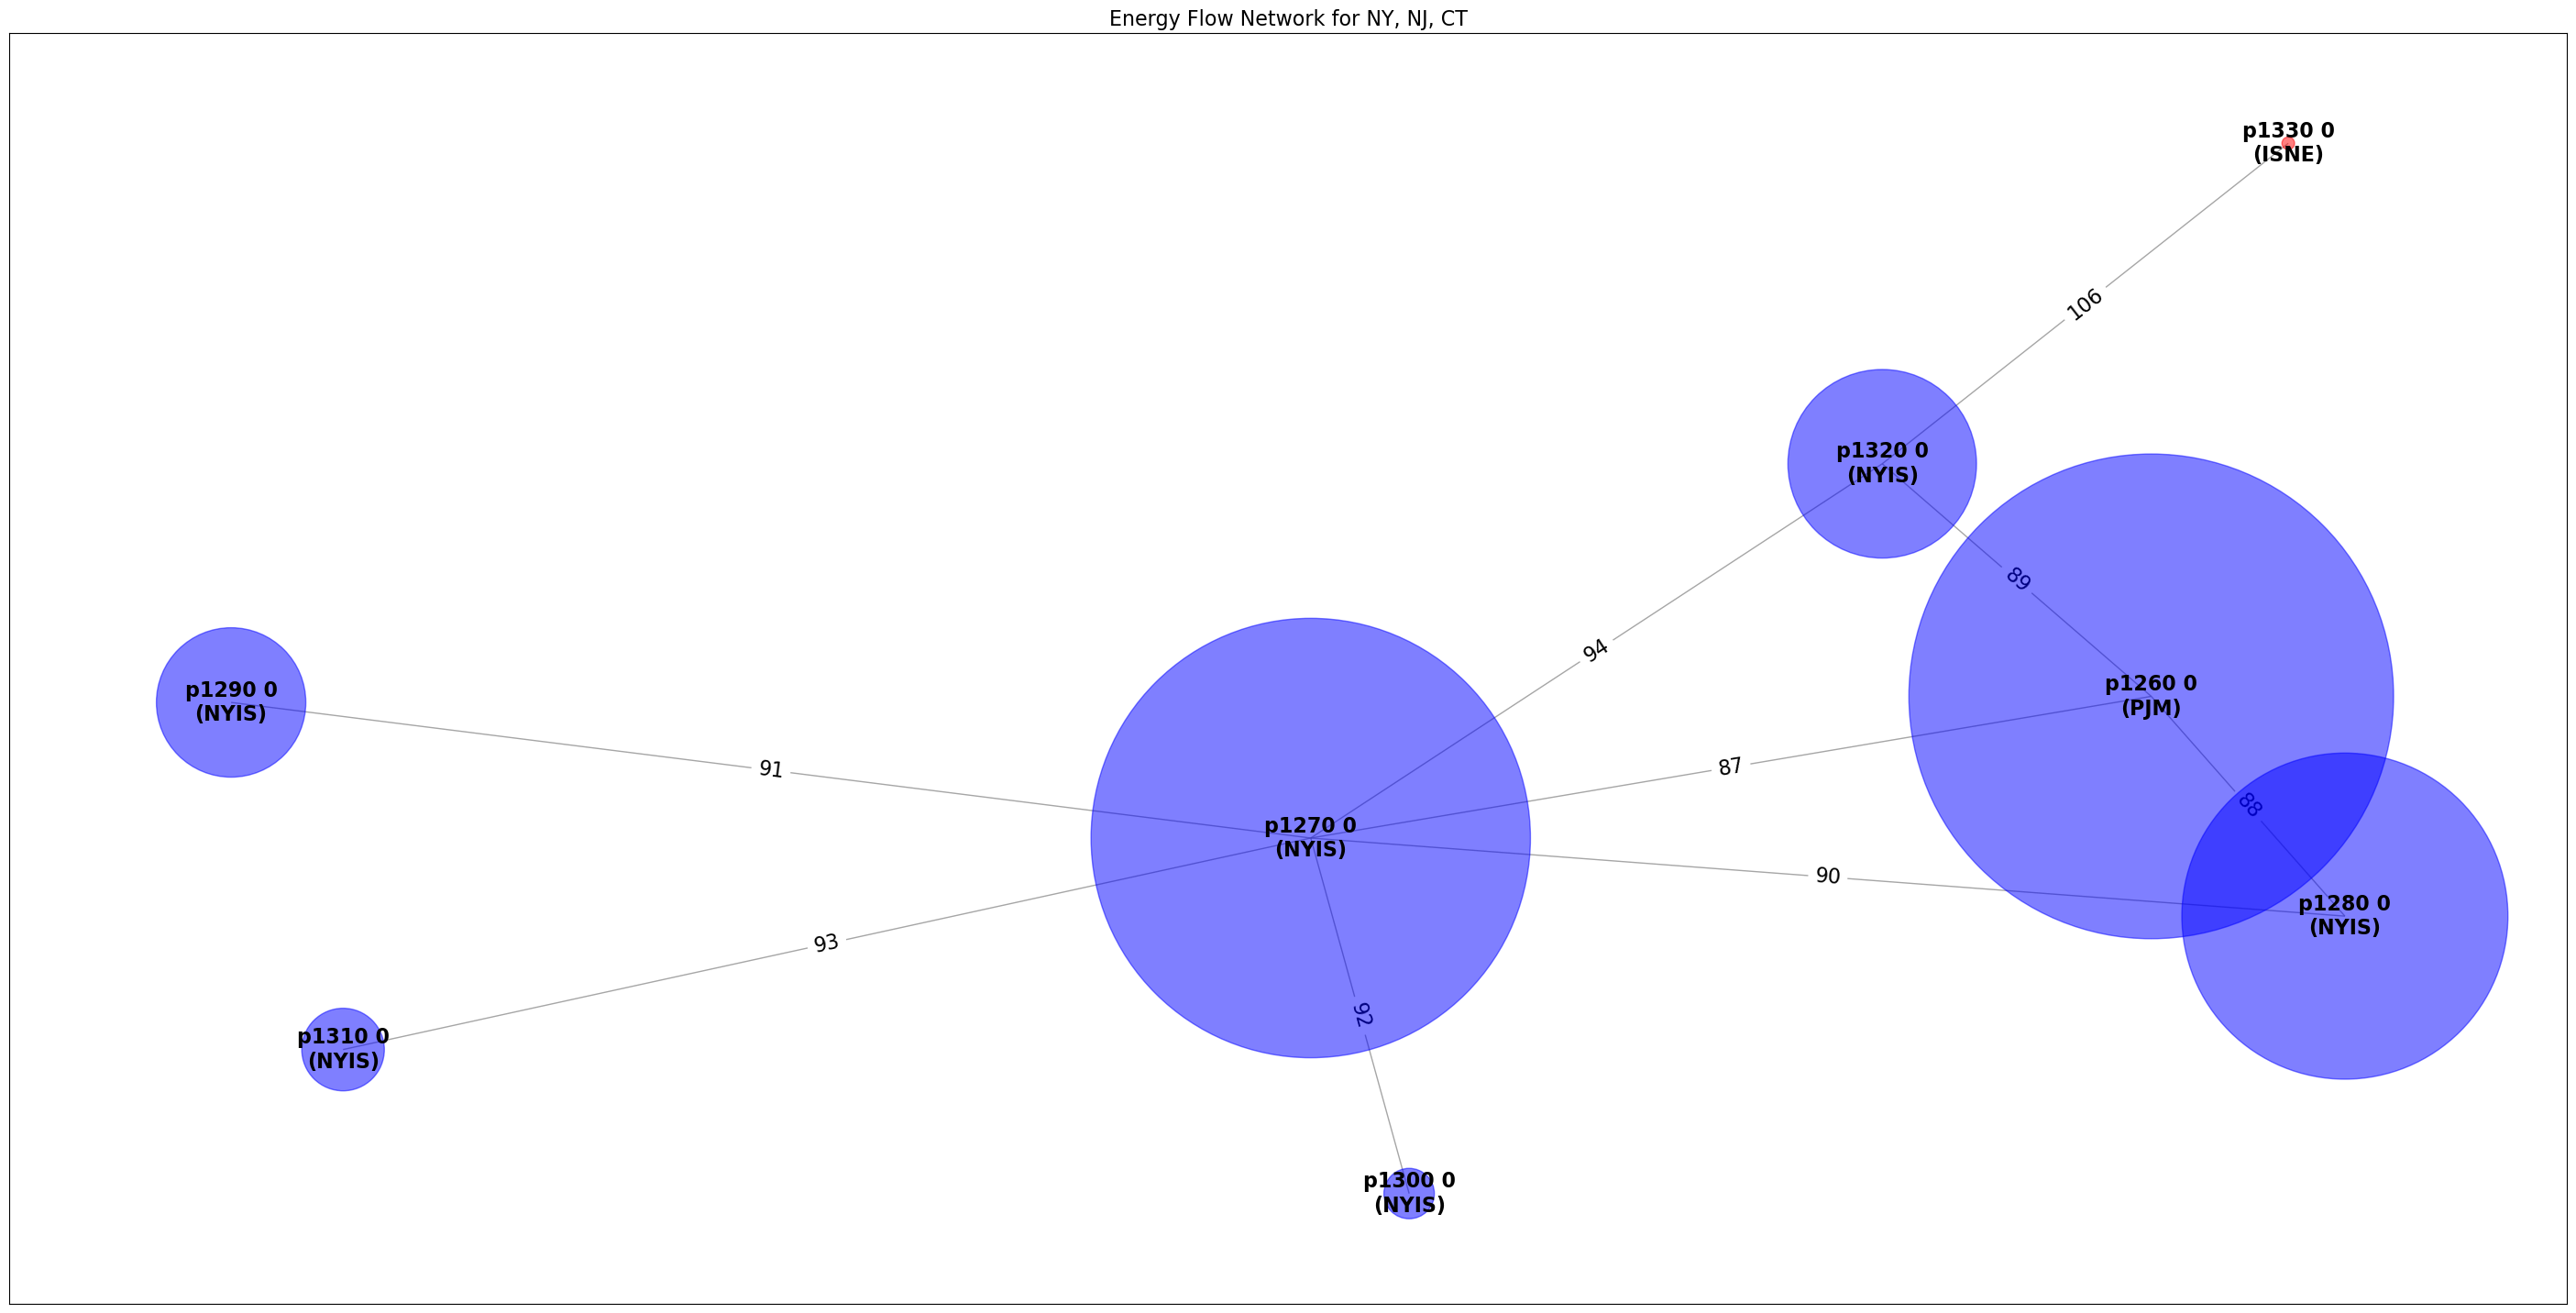

In [698]:
def prepare_lines(df, state: str, start_date, end_date):
    # Filter data by state
    df_filtered = df.query('reeds_state == @state')
    
    # Convert columns to datetime
    df_filtered.columns = pd.to_datetime(df_filtered.columns)
    
    # Filter columns by date range
    date_range_condition = (df_filtered.columns >= start_date) & (df_filtered.columns <= end_date)
    filtered_columns = df_filtered.columns[date_range_condition]
    
    # Filter DataFrame columns
    df_filtered = df_filtered[filtered_columns]
    
    # Aggregate the flows for the specified date range
    df_aggregated = df_filtered.sum(axis=1)
    
    # Drop any rows where the aggregated flow is NaN
    df_aggregated = df_aggregated.dropna()
    
    return df_aggregated

def build_network(df_aggregated):
    G = nx.Graph()

    # Add nodes and edges
    for (Line, bus0, bus1, _, reeds_zone, _, reeds_ba), flow in df_aggregated.items():
        if flow != 0:
            # Determine the color based on flow direction
            color = 'blue' if flow > 0 else 'red'
            abs_flow = abs(flow)
            
            # Add nodes with size, flow attributes, and reeds_ba
            if not G.has_node(bus0):
                G.add_node(bus0, label=bus0, size=abs_flow, incoming=0, outgoing=0, color=color, ba=reeds_ba)
            else:
                if color == 'blue':
                    G.nodes[bus0]['outgoing'] += abs_flow
                else:
                    G.nodes[bus0]['incoming'] += abs_flow
                G.nodes[bus0]['size'] += abs_flow
                G.nodes[bus0]['color'] = color
                G.nodes[bus0]['ba'] = reeds_ba
            
            if not G.has_node(bus1):
                G.add_node(bus1, label=bus1, size=abs_flow, incoming=0, outgoing=0, color=color, ba=reeds_ba)
            else:
                if color == 'blue':
                    G.nodes[bus1]['incoming'] += abs_flow
                else:
                    G.nodes[bus1]['outgoing'] += abs_flow
                G.nodes[bus1]['size'] += abs_flow
                G.nodes[bus1]['color'] = color
                G.nodes[bus1]['ba'] = reeds_ba
            
            # Add edge with line number
            G.add_edge(bus0, bus1, line=Line)
    

    return G

def plot_network(G, state:str):
    # Calculate node sizes based on flow (scaled up for better visibility)
    node_sizes = [G.nodes[node].get('size', 100) * 6 for node in G.nodes]
    
    # Use a layout for the network
    pos = nx.spring_layout(G, seed=42)
    
    plt.figure(figsize=(36, 18))
    
    # Draw nodes
    node_colors = [G.nodes[node].get('color', 'gray') for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.5)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.7)
    
    # Draw node labels including ba information
    node_labels = {node: f"{node}\n({G.nodes[node].get('ba', 'N/A')})" for node in G.nodes}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=16, font_weight='bold')
    
    # Draw edge labels (line numbers)
    edge_labels = nx.get_edge_attributes(G, 'line')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5, font_size=16)
    
    plt.title(f'Energy Flow Network for {state}', fontsize=16)
    plt.show()

def create_energy_flow_network(df, state, start_date, end_date):
    df_aggregated = prepare_lines(df, state, start_date, end_date)
    G = build_network(df_aggregated)
    plot_network(G, "NY, NJ, CT")


# Example usage
state = ['NY', 'NJ', 'CT']
start_date = pd.to_datetime('2019-01-06')
end_date = pd.to_datetime('2019-01-30')

# Assuming df is your DataFrame
create_energy_flow_network(lines0_weekly, state, start_date, end_date)

In [679]:

prepare_lines(lines0_weekly, "NY", "2019-01-01", "2019-01-30")

Line  bus0     bus1     interconnect  reeds_state  reeds_zone  reeds_ba
90    p1270 0  p1280 0  Eastern       NY           p127        NYIS        1539.999990
91    p1270 0  p1290 0  Eastern       NY           p127        NYIS        2294.744473
92    p1270 0  p1300 0  Eastern       NY           p127        NYIS         261.287406
93    p1270 0  p1310 0  Eastern       NY           p127        NYIS         700.566240
94    p1270 0  p1320 0  Eastern       NY           p127        NYIS        1965.194139
95    p1280 0  p1330 0  Eastern       NY           p128        NYIS           0.000000
dtype: float64